In [2]:
import pandas as pd

In [3]:
csv_file= "https://drive.google.com/uc?id=1_rK8orgmy-GnfKAkqh5qHk-6s_pDnGxj"
df = pd.read_csv(csv_file)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
df.rename(columns={"PAY_0": "PAY_1"}, inplace=True)

In [6]:
df.rename(columns={"default.payment.next.month": "DEFAULT"}, inplace=True)

#### Find out which type has more defaulters
#### 1 = Male , 2 = Female

In [7]:
#Calculater number of male and female clients out of all defaulters
df[["ID","SEX","DEFAULT"]].groupby(by=["DEFAULT","SEX"]).count()

ID
DEFAULT SEX       
0       1     9015
        2    14349
1       1     2873
        2     3763

In [8]:
#Calculate number of clients by education level out of all defaulters
df[["ID","EDUCATION","DEFAULT"]].groupby(by=["DEFAULT","EDUCATION"]).count()

ID
DEFAULT EDUCATION       
0       0             14
        1           8549
        2          10700
        3           3680
        4            116
        5            262
        6             43
1       1           2036
        2           3330
        3           1237
        4              7
        5             18
        6              8

In [9]:
# Group education levels: 0, 4, 5, 6 -> "Others"
# 1 -> Graduate, 2 -> University, 3 -> High School
education_mapping = {0: "Others", 1: "Graduate", 2: "University", 3: "High School", 4: "Others", 5: "Others", 6: "Others"}
df["EDUCATION_GROUPED"] = df["EDUCATION"].map(education_mapping)

# Now group by DEFAULT and new EDUCATION_GROUPED column
df[["ID","EDUCATION_GROUPED","DEFAULT"]].groupby(by=["DEFAULT","EDUCATION_GROUPED"]).count()

ID
DEFAULT EDUCATION_GROUPED       
0       Graduate            8549
        High School         3680
        Others               435
        University         10700
1       Graduate            2036
        High School         1237
        Others                33
        University          3330

In [10]:
# Calculate defaulter percentages by gender
sex_default = df[["ID","SEX","DEFAULT"]].groupby(by=["DEFAULT","SEX"]).count()

# Get counts for males (SEX=1) and females (SEX=2)
male_total = sex_default.loc[(0, 1), "ID"] + sex_default.loc[(1, 1), "ID"]
female_total = sex_default.loc[(0, 2), "ID"] + sex_default.loc[(1, 2), "ID"]

male_defaulters = sex_default.loc[(1, 1), "ID"]
female_defaulters = sex_default.loc[(1, 2), "ID"]

# Calculate percentages
t_male = (male_defaulters / male_total) * 100
t_female = (female_defaulters / female_total) * 100

print(f"Male defaulter percentage: {t_male:.2f}%")
print(f"Female defaulter percentage: {t_female:.2f}%")

Male defaulter percentage: 24.17%
Female defaulter percentage: 20.78%


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn import metrics

# Prepare features and target variable
features = list(df.columns)
# Remove non-feature columns
for c in ("ID","DEFAULT","EDUCATION_GROUPED"):
    if c in features:
        features.remove(c)
# Ensure we include the encoded education column if present
if "EDUCATION_GROUPED_ENC" in df.columns and "EDUCATION_GROUPED_ENC" not in features:
    features.append("EDUCATION_GROUPED_ENC")

# Build X using numeric columns only (safety) and handle missing values
X = df[features].select_dtypes(include=["number"]).copy()
X = X.fillna(0)

y = df["DEFAULT"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      7040
           1       0.38      0.42      0.40      1960

    accuracy                           0.73      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.74      0.73      0.73      9000

Confusion matrix:
[[5712 1328]
 [1140  820]]


In [12]:
# Calculate average age of defaulters and non-defaulters
avg_age_by_default = df.groupby("DEFAULT")["AGE"].mean()

print("Average Age by Default Status:")
print(f"Non-Defaulters (DEFAULT=0): {avg_age_by_default[0]:.2f} years")
print(f"Defaulters (DEFAULT=1): {avg_age_by_default[1]:.2f} years")
print(f"\nDifference: {abs(avg_age_by_default[0] - avg_age_by_default[1]):.2f} years")

Average Age by Default Status:
Non-Defaulters (DEFAULT=0): 35.42 years
Defaulters (DEFAULT=1): 35.73 years

Difference: 0.31 years


Correlation matrix (numeric columns):


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,1.000000,0.026179,0.018497,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,...,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,...,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,...,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,0.039177,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,...,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.029079,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,...,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.018678,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,...,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_1,-0.030575,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,...,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,...,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,...,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.002735,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,...,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614


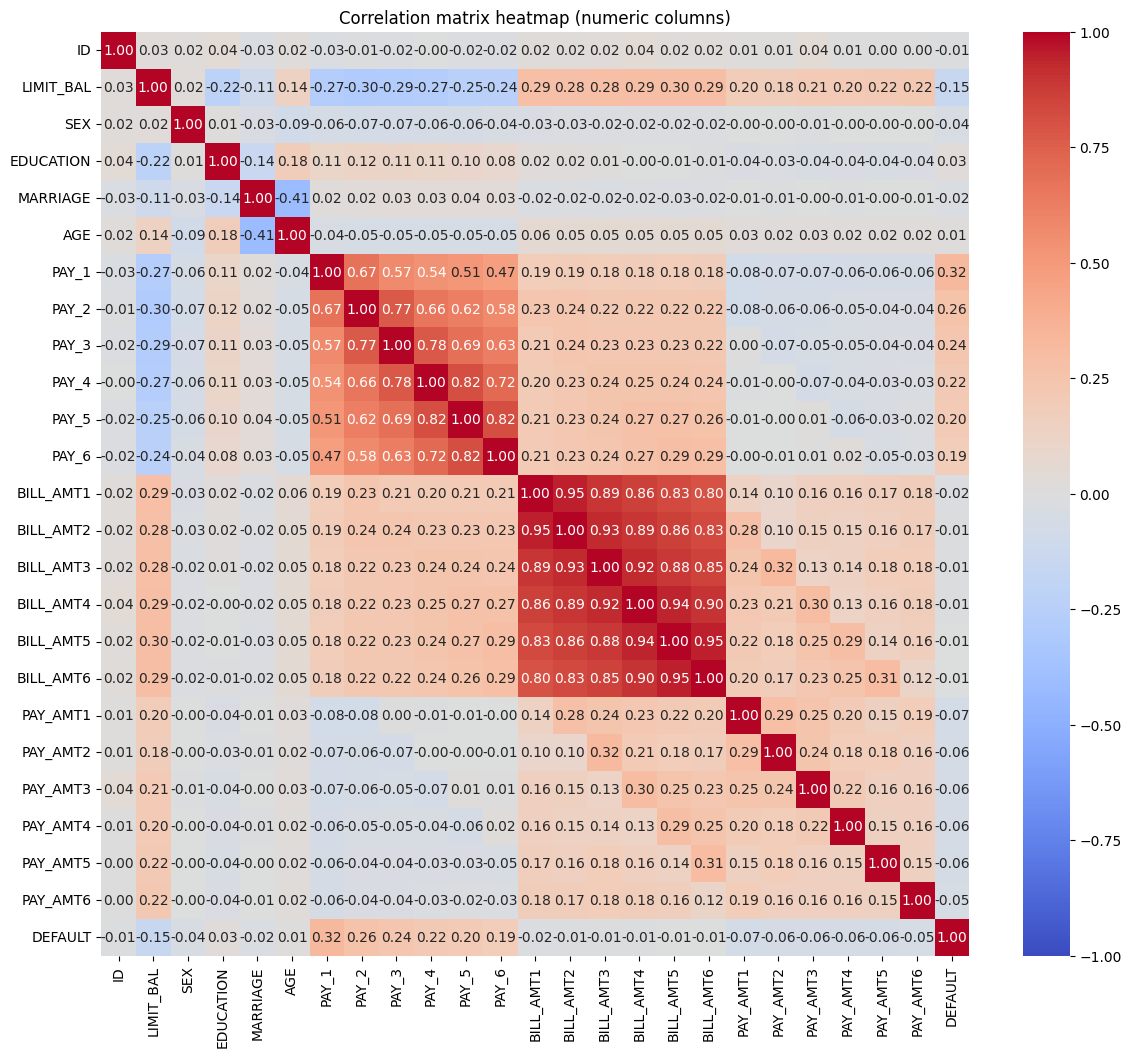

In [13]:
# Compute correlation matrix (numeric columns only) and show a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Use only numeric columns to avoid errors from string-valued columns
num_df = df.select_dtypes(include=["number"]).copy()

corr = num_df.corr()
print("Correlation matrix (numeric columns):")
display(corr)

plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix heatmap (numeric columns)")
plt.show()

In [14]:
# Encode `EDUCATION_GROUPED` ordinally for modeling (B)
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
# Fit on the column as strings to be safe
df["EDUCATION_GROUPED_ENC"] = enc.fit_transform(df[["EDUCATION_GROUPED"]].astype(str))
# Show mapping
mapping = {cat: i for i, cat in enumerate(enc.categories_[0])}
print("EDUCATION_GROUPED -> ordinal encoding mapping:")
print(mapping)
# Quick check
print(df[["EDUCATION_GROUPED","EDUCATION_GROUPED_ENC"]].head())

EDUCATION_GROUPED -> ordinal encoding mapping:
{'Graduate': 0, 'High School': 1, 'Others': 2, 'University': 3}
  EDUCATION_GROUPED  EDUCATION_GROUPED_ENC
0        University                    3.0
1        University                    3.0
2        University                    3.0
3        University                    3.0
4        University                    3.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

# Prepare features and target variable
features = list(df.columns)
features.remove("ID")
features.remove("DEFAULT")

# Copy features into X
X = df[features].copy()
y = df["DEFAULT"]

# Encode EDUCATION_GROUPED ordinally if present
if "EDUCATION_GROUPED" in X.columns:
    enc = OrdinalEncoder()
    X[["EDUCATION_GROUPED"]] = enc.fit_transform(X[["EDUCATION_GROUPED"]])
    mapping = {cat: idx for idx, cat in enumerate(enc.categories_[0])}
    print("Ordinal encoding mapping for EDUCATION_GROUPED:", mapping)

# Ensure all features are numeric and handle missing values
non_numeric = X.select_dtypes(exclude=["number"]).columns.tolist()
if non_numeric:
    raise ValueError(f"Non-numeric columns remain: {non_numeric}")

X = X.fillna(0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))



Ordinal encoding mapping for EDUCATION_GROUPED: {'Graduate': 0, 'High School': 1, 'Others': 2, 'University': 3}


Classification report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      7040
           1       0.38      0.42      0.40      1960

    accuracy                           0.73      9000
   macro avg       0.61      0.62      0.61      9000
weighted avg       0.74      0.73      0.73      9000

Confusion matrix:
[[5711 1329]
 [1129  831]]


In [20]:
from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

dot_data = StringIO()
export_graphviz(model, out_file=dot_data,
                filled=True, rounded=True, feature_names=features, class_names=["0", "1"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("decision_tree.png")
Image(graph.create_png())


InvocationException: GraphViz's executables not found